***
<left>
    <img style="float: left;" src="Mix_colour.png" width="200"></img>
</left>

<br/><br/>
<br/><br/>

### You have learned a lot about Unsupervised Learning already. Go through the following self-study material to discover more examples, deepen your knowledge and broaden your view on Unsupervised Learning. Make sure to carefully read through the following pages, the more thorough you will go through the summary, the easier you will find the assignment. 

## Unsupervised learning
In this section you will learn about unsupervised learning from the context of clustering.



### KMeans clustering
If we are tasked with the problem of finding classes in data when there are no **labels** available, there are a few options, but none of them is simpler than KMeans.

To illustrate how KMeans clustering works, we will use the Iris dataset. Suppose we want to classify the flowers, but somehow we don't have knowledge of the labels.

In [1]:
import pandas as pd
iris = pd.read_csv('../../Data/iris.csv')
# Clean the first column
iris = iris[iris.columns[1:]]
iris.head(2)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


In [2]:
feature_columns = iris.columns[:4]
target_column = iris.columns[-1]
X = iris[feature_columns]
y = iris[target_column]

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [4]:
import numpy as np
np.random.seed(10)
lenc = LabelEncoder()
km = KMeans(n_clusters=3)
# This fits the KMeans model, note that we are only feeding in X,
# which is just information about Sepal and Petal, km does not know
# the classes
km.fit(X)
# Since KMeans outputs numbers instead of class names let us introduce a label
# encoder, i.e. it maps label names into numbers between 0 and 1
lenc.fit(y)

# Now if we are lucky we actually got all three correct, i.e. KMeans does not
# know what is related to what so it will just form three classes. There are
# six different orders and only one is right. Lets hope we got it right

from sklearn.metrics import classification_report
print(classification_report(y,lenc.inverse_transform(km.predict(X))))
print('Cluster centers')
print(km.cluster_centers_)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.77      0.96      0.86        50
   virginica       0.95      0.72      0.82        50

    accuracy                           0.89       150
   macro avg       0.91      0.89      0.89       150
weighted avg       0.91      0.89      0.89       150

Cluster centers
[[5.006      3.428      1.462      0.246     ]
 [5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]]


This is not too bad, the recall of virginica is not the best but we did not tell it anything. The lesson to be learned here is that if we don't have access to class labels we can still do something but it will not be as good. In this dataset we were slightly lucky, first since we knew how many clusters there were and secondly that they are of the same size. If they would have been very uneven this can be very tricky. Lastly the decision boundaries are fairly flat which also makes life easier.

If you wish to experiment, you can try to rerun the above code snippet with different values of the `random_state` parameter and see what happens.

### KMeans: How does it work?

Let us say that we are given a training set $\{x^{(1)}, \ldots, x^{(m)}\}$, and we wish to, as above, find a number of groups. The groups are commonly referred to as clusters. The idea is that the groups found will be cohesive and comparable somehow. 

Let us look at some example data:

In [5]:
np.random.seed(10)
a = np.random.normal(size=(100,2))
b = np.random.normal(size=(100,2),loc=[3,3])
c = np.random.normal(size=(100,2),loc=[3,-3])

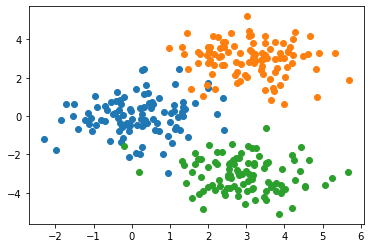

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(a[:,0],a[:,1])
plt.scatter(b[:,0],b[:,1])
plt.scatter(c[:,0],c[:,1])
plt.show()

As we can see in the above plot, we have sampled from three different 2d-normal distributions with different mean values. In fact this is exactly what the k-means algorithm will solve, i.e. it will find the optimal centers from a dataset with samples from different spherical Gaussians.

Let us quickly check how well it performs before we go on and describe how the algorithm actually works:

In [7]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
# Let us add all the data into one array as we want to forget where they came from
X = np.concatenate([a,b,c],axis=0)

# Fit the KMeans model on this data
km.fit(X)

KMeans(n_clusters=3)

In [8]:
# Now we wish to first, output the centers it has found, remember that it was [0,0], [3,3] and [3,-3]
km.cluster_centers_

array([[ 0.09212836, -0.03859481],
       [ 3.08232079,  2.93598905],
       [ 2.942102  , -3.04551641]])

As we can see it did fairly well and is not too far away from the truth, let us now check visually how it grouped the points.

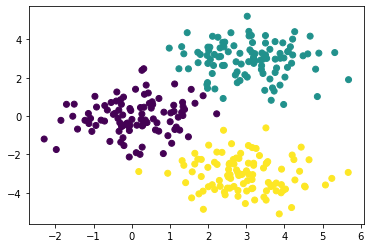

In [9]:
plt.scatter(X[:,0],X[:,1], c=km.predict(X))
plt.show()

One thing we notice when comparing this scatter plot vs the true scatter plot is that the `KMeans` algorithm will make mistakes when there is *mixing* or *overlap*, and that the KMeans algorithm has hard decision boundaries, let us look at them here. (ps. don't worry about the complexity of the code below, it is just for illustrative purposes)

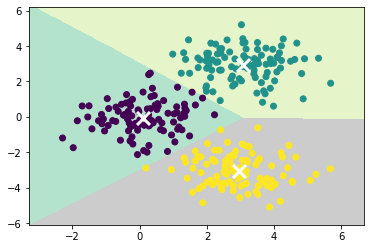

In [10]:
# Plot the decision boundary. For that, we will assign a color to each
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Pastel2,
           aspect='auto', origin='lower')
plt.scatter(X[:,0],X[:,1], c=km.predict(X))

centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)

Now that we know via examples how the result looks like and how the decision boundaries look like, let us go through the algorithm step by step:

Let us say that we are given a training set $\{x^{(1)}, \ldots, x^{(m)}\}$, where each data point is $n$-dimensional i.e $x^{(i)} \in \mathbb{R}^n$. The algorithm proceeds as follows:

1. Choose the number of clusters as k.
2. Initialize the set of cluster centroids $\{\mu_1,\ldots,\mu_k\}$, where all of the centroids are $n$-dimensional.
3. For every $i$ do:
    * $c^{(i)} := \underset{j}{\text{arg min}} || x^{(i)} - \mu_j ||$.
4. For every $j$ do:
    * $\displaystyle{\mu_j = \frac{\sum_{i=1}^m 1\{c^{(i)} = j\} x^{(i)}}{\sum_{i=1}^m 1\{c^{(i)} = j\}}}$.
5. Go to 3 until there is either no more movement of the cluster centers or if the centers move less than a set threshold.

The initialization of the cluster centers can be done in several ways, either we just randomly initialize them or we use a sampling algorithm that is constructed to choose a good candidate based on the data. The sampling version is what is implemented in `Scikit` and is called `KMeans++`.

So what is actually going on here?

1. We start with the initialized cluster centers and for each data point we assign the index to the cluster center that is closest to that particular data point, this is $c^{(i)}$.
2. Once we have assigned all data points to a cluster center, we compute the average location of the points assigned to a cluster and use that as the updated centroid for the cluster.
3. Now we repeat step 1 and 2 until convergence.

Will it converge? Well, yes, in some sense. See for instance [Bottou, Bengio](http://www.iro.umontreal.ca/~lisa/pointeurs/kmeans-nips7.pdf).

### The elbow method for finding the number of clusters using inertia

The natural question to ask when implementing KMeans is how to choose the number of clusters if we don't have information about how many clusters there should be? There is an approach called "the elbow method" that can be used. We will briefly describe it here. If you are interested in details we encourage you to dig deeper, for example take a look at [wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

This method calculates the model's *inertia*, which is the sum of squared distances of the data-points to their closest cluster center, for various values of $k$ (i.e. different number of clusters). Plotting the number of clusters vs. the inertia results in a figure that will (in a good scenario) be steep in the beginning and at some point flatten out.
The name "elbow method" comes from the figure's shape, that can be thought of as "an arm", and the point where the figure goes from steep to flat is the "elbow", which gives you an optimal value of the number of clusters.

To justify this choice of number of clusters let's think about a toy example. 
Let X be a dataset of 5 points, each labeled with a different number. 
Or equivalently there are 5 clusters, each containing one of the points. Then performing KMeans would group these 5 points into $k$ different groups. The inertia is zero for $k=5$ (if KMeans would manage to put all 5 points in different groups); it is greater than zero for $k<5$, and it will still be zero for $k>5$. Hence the "best" choice would be numbers of clusters=5. 

Obviously, we usually have clusters with more than one point and our clusters may (and most often will) be mixed into other clusters, so the inertia will **not** be zero, and generally we should **not** be looking for when the inertia is zero, but rather when the inertia "drastically" changes. 

Let's see how the elbow method works on the data X. Indeed, in the resulting plot "the elbow" is located at $k=3$, which is evidence that $k=3$ is indeed a good choice of the number of clusters for this dataset.

Text(0.5, 1.0, 'Elbow curve')

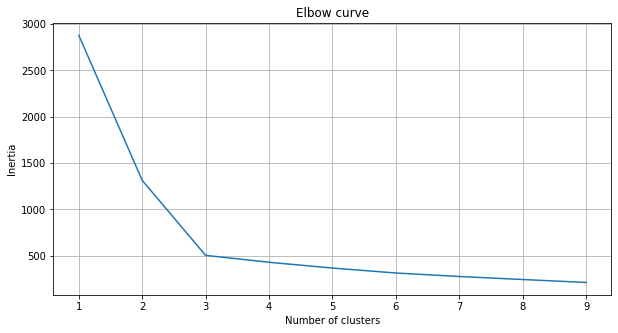

In [11]:
distorsions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), distorsions)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.title('Elbow curve')

### Final note
There are a lot of algorithms that are classified as unsupervised, KMeans is only an example and perhaps the most classical one. Unsupervised learning is normally very hard and in the above examples we have hidden the problem of choosing the right amount of cluster centers. Generally it is not guaranteed that an unsupervised algorithm will produce something of value.

More algorithms will be introduced in the module _Models for Learning_.

## Dimensionality reduction

In dimensionality reduction the general idea is to find a simpler representation of the data, think of it as a "compression". There are a few reasons why you would want to do this:

* Dimensionality reduction as a first step before building a prediction model is an effective way of simplifying a model and thus possibly reducing overfitting.
* As in clustering, we are actually building a model of the data without knowing anything. It can thus sometimes be used to draw conclusions about the problem at hand. Such a model can also be used in Anomaly detection.
* Due to the "[curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)" it can sometimes be used as a first step before applying a model that is computationally intensive.

### PCA

Principal component analysis (PCA) is a classical way to reduce the dimensionality of data. The idea is to find a lower dimensional representation of your data that describes as much of the variance in the data as possible. 

Consider the data given as a matrix $X$, with $n$ rows and $m$ columns, assume furthermore that we have used a `StandardScaler` on each column, or at least shifted the mean value of each column to zero. As always, each column will be considered as a feature and each row as a datapoint. To find the directions that maximize the variance we do as follows: (The following derivation is conceptually very simple but the notation makes it hard to read, it is therefore recommended to circle back regularly when reading the example below).

Consider an $m$-dimensional unit vector $w$, the projection of a $m$-dimensional vector $v$ onto $w$ can be written as
$(v \cdot w)w$, where $\cdot$ represents the [dot product](https://en.wikipedia.org/wiki/Dot_product) between the vector $v$ and $w$. So the variance of the data along vector $w$ can be written as

$$\sum_{j=1}^n ((x_j \cdot w) - \overline{(x_j \cdot w)})^2$$

where $x_j$ is the $m$-dimensional vector that represents row $j$ in matrix $X$, furthermore $\overline{(v \cdot w)}$ is the mean value of $v \cdot w$ over all the rows, but remember each column had mean zero, therefore this number has mean zero. Thus this simplifies to

$$\sum_{j=1}^n (x_j \cdot w)^2.$$

Since we are interested in finding the direction $w$ that maximizes this variance we just find the following maximum

$$w_{(1)} = \max_{||w||=1} \sum_{j=1}^n (x_j \cdot w)^2.$$

The vector $w_{(1)}$ is called the first principal component and is the direction in which the data has the maximum variance.  To find the second, third and so on... component we do as follows, let us assume that we have found $k$ components and we wish to find the $k+1$th component:

$$X_{(k)} = X - \sum_{i=1}^k X_{(i-1)} w_{(i)} w_{(i)}^T, \quad X_{(0)}=X $$

this formula is just matrix notation for projecting each vector in $X$ onto the principal component vectors $w_{(i)}$ and removing that part from $X$. We can interpret this as $X$ with all the $k$ first principal components removed. Then we repeat the step to find the first one but for $X_{(k)}$, and it looks like

$$w_{(k+1)} = \max_{||w||=1} \sum_{j=1}^n (x_{(k)j} \cdot w)^2,$$

where $x_{(k)j}$ is the $j$th row of $X_{(k)}$ as before.

This procedure can be continued until we have reached $m$ principal components. Since the above can be quite technical and difficult to understand, let us begin with a two dimensional example.

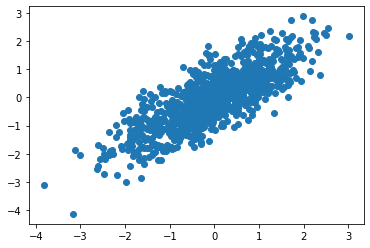

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#help(np.random.multivariate_normal)
X = np.random.multivariate_normal(mean=(0,0),cov=[(1,0.8),(0.8,1)],size=1000)
plt.scatter(X[:,0],X[:,1])

The above is our data and we now wish to find the direction of the greatest variance. Remember that our assumption was that each feature had mean 0, therefore we apply a `StandardScaler`:

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_trans = sc.fit_transform(X)

In numpy the dot product can be written as `(np.sum(X_trans*w,axis=1)`, where the `X_trans` matrix has dimensions $(1000,2)$ i.e. we have two dimensions, $w$ is the unit vector. 

In [14]:
f = lambda w: -np.sum((np.sum(X_trans*w,axis=1))**2)

In [15]:
# This is the constraint that $||w|| = 1$, its something we want to keep during our optimization
cons = ({'type': 'eq', 'fun': lambda w:  1-(np.sum(w**2))})

In [16]:
# We use scipy minimize to find the values we are interested in, it needs
# the function, an initial guess and the constraint
from scipy.optimize import minimize
ans1 = minimize(f, x0=(0,1),constraints=cons)

In [17]:
# This just creates two points on the line that is made up by the vector
# that we found from the minimization
x1 = ans1.x*np.linspace(-3,3,2).reshape(2,1)

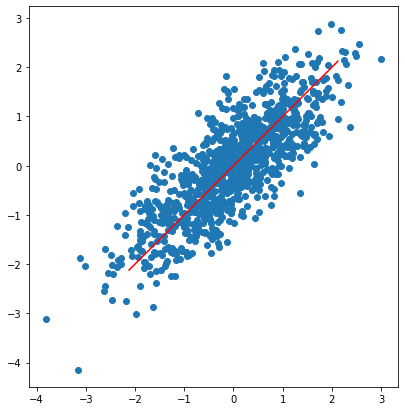

In [18]:
plt.figure(figsize=(7,7))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(X[:,0],X[:,1])
plt.plot(x1[:,0],x1[:,1],color='red')

The next step now is to remove this component and see what we have left.

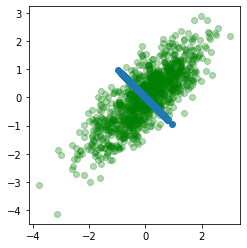

In [19]:
plt.gca().set_aspect('equal', adjustable='box')
X1 = X_trans - np.sum(X_trans*ans1.x,axis=1).reshape(-1,1)*ans1.x
plt.scatter(X_trans[:,0],X_trans[:,1],alpha=0.3,color='green')
plt.scatter(X1[:,0],X1[:,1])

So you see the expression 

$$X_{(k)} = X - \sum_{i=1}^k X_{(i-1)} w_{(i)} w_{(i)}^T, \quad X_{(0)}=X $$

has a simple geometric interpretation, i.e. that all variation in the direction of the $k$ first components, or in this case the first component, is taken away and what remains is a variation [orthogonal](https://en.wikipedia.org/wiki/Orthogonality) to those components.

So let's continue and see what we do with the next component.

In [20]:
f1 = lambda w: -np.sum((np.sum(X1*w,axis=1))**2)

In [21]:
ans = minimize(f1, x0=(0,1),constraints=cons)

In [22]:
x2 = ans.x*np.linspace(-3,3,2).reshape(2,1)

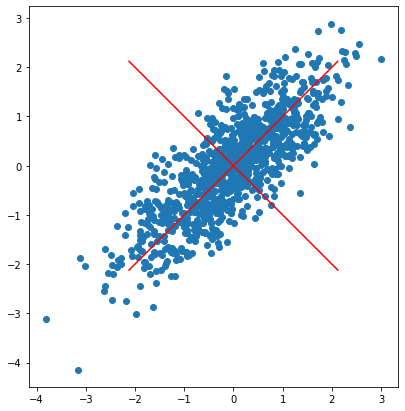

In [23]:
plt.figure(figsize=(7,7))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(X[:,0],X[:,1])
plt.plot(x1[:,0],x1[:,1],color='red')
plt.plot(x2[:,0],x2[:,1],color='red')

There are different ways to compute this in a [good numerical](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) way, for instance [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). `sklearn` has implemented a version of PCA that we could have used to compute the components, let's try it:

In [24]:
from sklearn.decomposition import PCA
# We have to specify the number of components, this can be any number less than the dimension
pca = PCA(n_components=2) 
pca.fit(X_trans)

PCA(n_components=2)

In [25]:
pca.components_

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

As we can see this found the same components except for direction (+ or -).

So since we usually want to use the PCA to do dimensionality reduction how do we do that? Basically, since the PCA picks the components such that they maximize the variance we can cut short and select the $k$ first components. The way to measure how good these components describe the full data is by a metric called explained variance ratio. It is simply the `Percentage of variance explained by each of the selected components`.

Take the variance of each direction of the components of the PCA, take a sum of them and count for each component the percentage of total variance this component contributes with. `sklearn` has a variable for this.

In [26]:
pca.explained_variance_ratio_

array([0.90120222, 0.09879778])

So we see that the first component describes around $90\%$ of the variance and thus reducing to one dimension only reduces $10\%$ of the information. In general there is always a tradeoff between how much of the information you wish to retain and how much complexity you want in terms of number of dimensions.

Let us go back to a classification problem with lots of uninformative features and see how much we can reduce.

The data is from [Internet Advertisements Data Set](https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements).

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../../Data/ad_data.data',header=None)
features = df.columns[:-1]
label = df.columns[-1]
df[features] = df[features].astype('float')
df = df.dropna()

X_data = df[features].astype('float').values
y_data = df[label].values

X_data = sc.fit_transform(X_data)

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,random_state=1)

In [29]:
pca_class = PCA()
pca_class.fit(X_train)

PCA()

Text(0.5, 1.0, 'Cumulative explained variance')

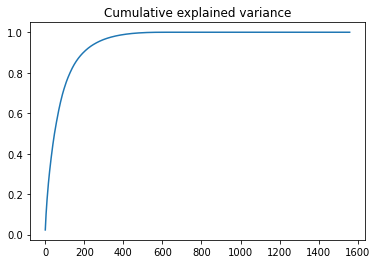

In [30]:
e_var_rat = np.cumsum(pca_class.explained_variance_ratio_)
plt.plot(range(1,len(e_var_rat)+1),e_var_rat)
plt.gca().set_title('Cumulative explained variance')

Let us say that we wish to retain $91\%$ of the variance, then we just need to cut the number of components in the right place, the choice is simply one of searching.

In [31]:
n_components = np.argmax(np.cumsum(pca_class.explained_variance_ratio_) > 0.91)+1
n_components

207

Let's do a logistic regression based on this number of components.

In [32]:
pca_reduced = PCA(n_components=n_components,svd_solver='full')
pca_reduced.fit(X_train)

PCA(n_components=207, svd_solver='full')

In [33]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(pca_reduced.transform(X_train),y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [34]:
from sklearn.metrics import average_precision_score
average_precision_score((y_test == 'ad.')*1, lr.predict_proba(pca_reduced.transform(X_test))[:,0])

0.9702770682275272

So how well did we do? Let us compare to a logistic regression trained on the full dataset:

In [35]:
from sklearn.linear_model import LogisticRegression
lr_no_pca = LogisticRegression()
lr_no_pca.fit(X_train,y_train)
average_precision_score((y_test == 'ad.')*1, lr_no_pca.predict_proba(X_test)[:,0])

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9564187627570909

### Conclusion

Using PCA for dimensionality reduction is a fairly useful technique to improve the performance of your models. Sometimes, however, it will reduce the performance of your models. This depends entirely on your specific data. Again we always have to do [model selection](https://scikit-learn.org/stable/model_selection.html).

## Feature reduction

Clustering can be a better way to encode your feature space than the features themselves. So the basic idea is that clustering finds similar values, similar values are then assigned a category which is finally OneHotEncoded before fed into a model. In the following example we again use the Iris dataset, where we encode $10$ clusters before we feed it to a logistic regression. This also allows a linear model like linear regression to learn nonlinear decision boundaries which might be beneficial.

In [37]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('../../Data/iris.csv')
X_data = df[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width']].values
X_data = sc.fit_transform(X_data)
y_data = df['Species']
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,random_state=1)

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

km = KMeans(n_clusters=10,n_init=20,random_state=1)
km.fit(X_train)

ohe = OneHotEncoder()
ohe.fit(km.predict(X_train).reshape(-1,1))

OneHotEncoder()

Let's investigate how these clusters were assigned.

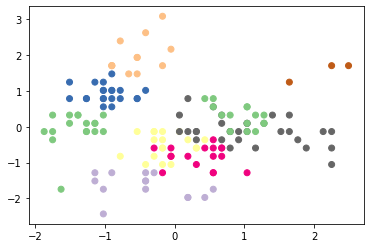

In [39]:
plt.scatter(X_data[:,0],X_data[:,1],c=km.predict(X_data),cmap=plt.cm.Accent)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
lr = LogisticRegression()
lr.fit(ohe.transform(km.predict(X_train).reshape(-1,1)),y_train)
print(classification_report(y_test,lr.predict(ohe.transform(km.predict(X_test).reshape(-1,1)))))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      1.00      1.00        16
   virginica       1.00      1.00      1.00         9

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [41]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)
print(classification_report(y_test,lr.predict(X_test)))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



As we see above, we actually managed to learn such good boundaries that we can make a perfect prediction on the test set.

This is of course just an example and you need to use [GridSearch](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html) to choose the best model and parameters.

## Anomaly detection

One common aspect of unsupervised learning is **Anomaly Detection**, this is a general method to simply find `anomalous` data from a dataset. What is anomalous is not well defined and depends on context. The simplest example of anomaly detection is in the context of a measurement, let us say that it is the weight of a person. Let us begin with an example of simulated data:

In [57]:
import numpy as np
W = 60+np.random.normal(size=1000)*20

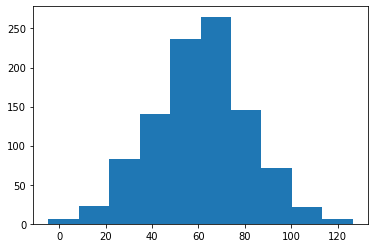

In [58]:
import matplotlib.pyplot as plt
_=plt.hist(W)

This data is designed to mimic the weight of individuals with mean 60kg. What is anomalous in this data? A standard way to define what is anomalous is to look at extremely small or large values, especially if your distribution is as above, a single peak. This relates to the concept of quantiles which is defined as follows:

For a given random variable $X$ with a continuous probability density function $f$, a quantile function $Q_f$ assigns to each quantile $q$ a value defined as
$$
    Q_f(q) = \{x: P(X < x) = q\}.
$$

We can interpret this as a cut point, of which $q*100$ percent of the data should end up being smaller than $Q_f(q)$. When testing hypothesis we usually speak of the $5\%$ and the $95\%$ quantiles, or also called percentiles.

For a finite dataset we can define quantiles using the data. Let us say that we have a dataset of length 100. Then, if we sort the values in increasing order, we have that each value represents the $x_i/100$ quantile.

Let us proceed with our example and compute some quantiles: Our dataset has length 1000, so if we want to compute the $0.01$ quantile we need to look at the $1000*0.01 = 10$th smallest value. We can find it by sorting and picking out the value at index $9$.

In [59]:
np.sort(W)[9]

11.731651160149987

Thus $1\%$ of the values fall below the value above, we can call these extremely small values and it coincides well with our intuition about anomalous values. Conversely we can look at the $0.99$ quantile, which corresponds to the $0.99*1000 = 990$th smallest value.

In [60]:
np.sort(W)[989]

109.95286196721062

Thus $1\%$ of the largest values fall above the value above, and can also be considered as extremely large.

It should be noted that extremely large and small might not be exactly what you want, for instance let us look at the following simulated data.

In [61]:
import numpy as np
Wa = 70+np.random.normal(size=1000)*10
Wb = 20+np.random.normal(size=1000)*10
W2 = np.concatenate([Wa,Wb])

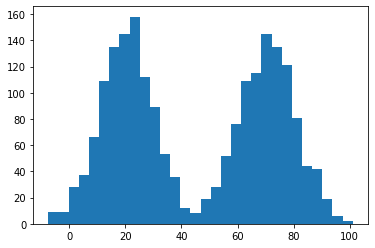

In [62]:
import matplotlib.pyplot as plt
_=plt.hist(W2,bins=30)

In the plot above, an unlikely value can be either extremely small or extremely large, but values that end up around 40-45 are also very unlikely. It would depend on context if those values are to be considered as anomalous.

Sometimes a common distribution from machine instrument data looks like:

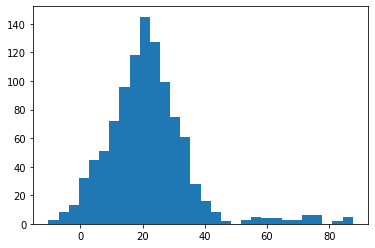

In [63]:
import numpy as np
Waa = 70+np.random.normal(size=40)*10
Wbb = 20+np.random.normal(size=1000)*10
W3 = np.concatenate([Waa,Wbb])
_ = plt.hist(W3,bins=30)

Suppose that the values that come from `Waa` are the actual failures that you are trying to catch with anomaly detection. In this case it would make sense to say that any value larger than 59 is probably an anomaly. If we would use quantiles in this case, we would underestimate the number of anomalies.

### Modelling the data

When looking for anomalies one way of approaching the problem is to build a model for the data, this could for instance be a PCA, a clustering model or perhaps a regression model from some of the variables to some of the others.

Let us take clustering as an example: let us imagine that we have a model that clusters our data into numbered clusters, like for instance `KMeans`. Each cluster has a center and we could therefore look at the distance from each point to that particular center, we could then label anomalies as abnormally large distance to the center of the cluster. In this case you get a cluster number specific cutoff value.

In [64]:
import pandas as pd

In [65]:
df = pd.read_csv('../../Data/SMHI2.csv',delimiter=';',header=None)

In [66]:
df.set_axis(['Date','Time','Temperature','Grade'],axis=1,inplace=True)

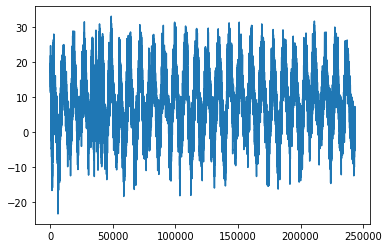

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(df['Temperature'])

The idea is now to create windows of length 24 hours, where each window moves forward 12 hours. This is called a sliding window with step-length 12h and window length 24h. We can perform that as follows, we begin by splitting the data into 24h blocks, then shift by 12h and create 24h blocks, to complete we simply "zip" these two arrays like a zipper.

In [68]:
def tumbling_window(X, window):
    X0 = X[:-window].reshape(-1,window)
    X1 = X[int(window/2):-int(window/2)].reshape(-1,window)
    return np.hstack([X0,X1]).reshape(-1,window)

In [69]:
import numpy as np

The data is not in a good format for us. One of the common problems with time series data is inconsistent sampling rate. Most of the data in these temperature measurements is sampled with an 1H interval, however this differs due to different circumstances.
The way we will solve this is by [imputing](https://en.wikipedia.org/wiki/Imputation_(statistics)) the missing data. The way we will solve this is by using pandas `date_range`, which generates a sequence of times with 1H in between, then we reindex the dataframe and use a method to fill in the missing values called "padding". What this means is that we use the last measured value as the value going forward.

But before that we need to parse the date in our data frame. The problem is that the date and the time are in two different columns, so let us first merge them into one column and then use pandas `to_datetime` to make the column into a datetime column. Then we use this newly created column and set is as the index for our data frame.

In [70]:
df['DateTime'] = df['Date'] +" " + df['Time']
date_and_time = pd.to_datetime(df['DateTime'],format='%Y-%m-%d %H:%M:%S')

In [71]:
df_dt_index = df.set_index(date_and_time)
full_date_range = pd.date_range(start=date_and_time.min(),end=date_and_time.max(),freq='1H')
df_imputed = df_dt_index.reindex(full_date_range,method='pad')

We will now window our data with window length 24, representing a 24h window, we will shift this window by half the length of the window to make our next window. The idea now is that we want to make sure that overlapping windows don't contain more data, i.e. we need to divide the data into the two windows. The idea is that the signal in each window is actually multiplied by $\sin^2$ scaled such that it encapsulates just one bump on the window, something like:

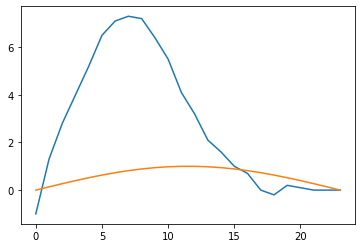

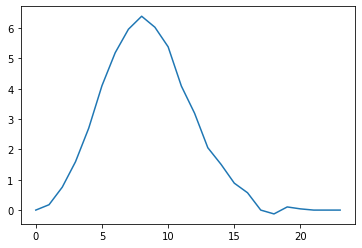

In [72]:
plt.plot(df['Temperature'][-24:].values)
plt.plot(np.sin(np.pi*np.linspace(0,1,24)))
plt.show()
plt.plot(df['Temperature'][-24:].values*np.sin(np.pi*np.linspace(0,1,24)))

The nice part about this is that shifting the sin half a window length and adding we get constant 1. Therefore this is a decomposition of the signal into chunks such that the sum of all the chunks becomes the full signal, and the windows have a continuous overlap.

In [73]:
# Technical problem is that the length has to be divisible by 24 so lets just be sloppy for this
# example and just cut to the closest multiple of 24
temp_vals = df_imputed['Temperature']
step_len = 24
data = tumbling_window(temp_vals[:int(len(temp_vals)/step_len)*step_len].values,step_len)
# For preparation we normalize the data in each window so that it always have mean 0 in the window
data_norm = (data - np.mean(data,axis=1).reshape(-1,1))

In [74]:
bump_func = np.array([np.sin(np.pi*i/23)**2 for i in range(0,24)])

In [75]:
bumped_data = data_norm*bump_func

The idea is now to perform clustering on the shapes of the temperature graphs of 24h sections, we will do that with `KMeans`.

In [76]:
from sklearn.cluster import KMeans
# Lets try 12 clusters for 12 months
km = KMeans(12)
km.fit(bumped_data)

KMeans(n_clusters=12)

We can now plot the cluster centers which will represent average 24h chunks.

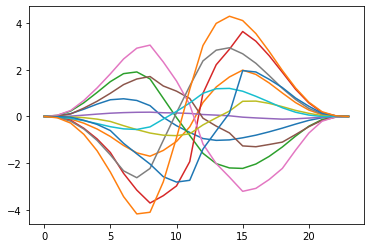

In [77]:
for cc in km.cluster_centers_:
    plt.plot(cc)

We can now use the predicted cluster number to reconstruct the temperature, i.e. this is exactly the distance to the cluster-center.

In [78]:
f = lambda x: km.cluster_centers_[x]
reconstruction_error = np.mean(np.abs(bumped_data-f(km.predict(bumped_data))),axis=1)

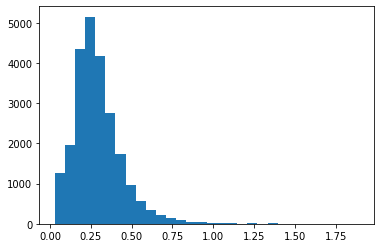

In [79]:
_=plt.hist(reconstruction_error,bins=30)

As we can see above there are some unusually large reconstruction errors, for instance the ones above 1. Let's have a look at one of them.

(-20.0, 30.0)

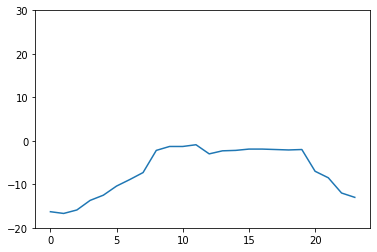

In [80]:
plt.plot(data[np.argmax((reconstruction_error > 1.5) & (reconstruction_error < 2)),:])
plt.ylim((-20,30))

This is certainly unusual, i.e. the temperature rose very quickly from around -16 to 0 in a few hours. Let us just see how the correlation is between the max and min of a 24h window and the value of the reconstruction error

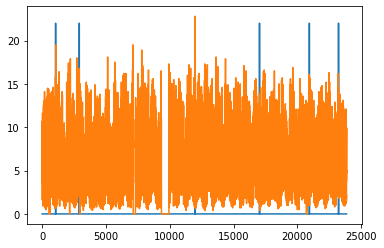

In [81]:
plt.plot((reconstruction_error > 1.5)*22)
plt.plot((np.max(data,axis=1)-np.min(data,axis=1)))

It seems that some of the things it's capturing is a large temperature swing during a 24h window, but that's not all.

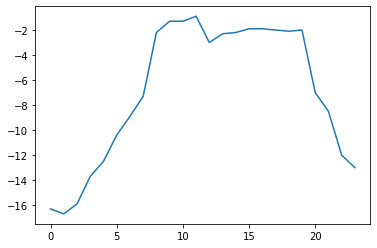

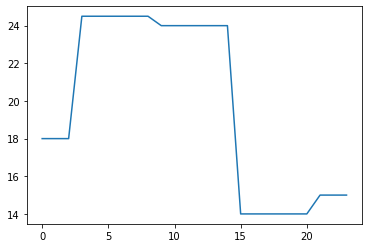

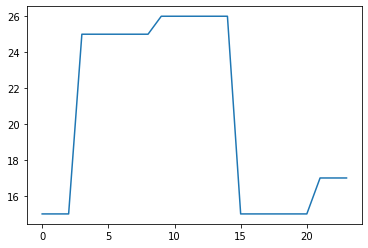

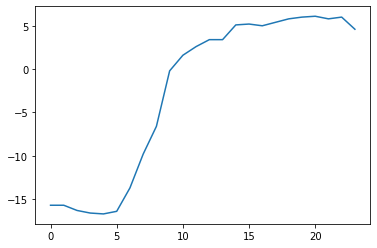

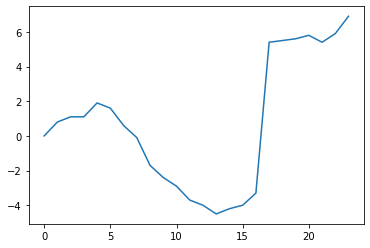

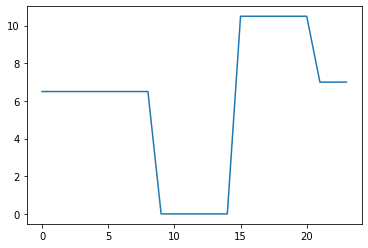

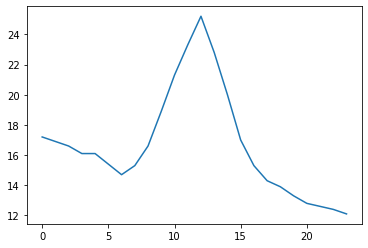

In [82]:
for graph in data[reconstruction_error > 1.5,:]:
    plt.plot(graph)
    plt.show()

So it seems that some anomalies happen when there is a lot of missing data (constant values) and the other happens with large temperature swings.

### Concluding remarks

The next step in detecting anomalies is to figure out if the anomalies that are reported make sense. Do they have a defining feature? Does it catch other data points with a similar defining feature?

***
<center>Combient Mix AB All Rights Reserved</center>

***